In [11]:
#pip install graphviz

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\aaa\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [71]:
# Data Processing
import pandas as pd
import numpy as np


# Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



# Tree Visualisation & plot visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
seed = 42

## Load  and prepare data

In [73]:
# Load in the data
df = pd.read_csv("D:\python\Python\wine\winequality-red.csv")
df.head()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [74]:
#rename column label for python recognizability all except "quality "..... which are appropriate 
df.rename(columns = {"fixed acidity": "fixed_acidity", "volatile acidity": "volatile_acidity",
                    "citric acid": "citric_acid", "residual sugar": "residual_sugar",
                    "chlorides": "chlorides", "free sulfur dioxide": "free_sulfur_dioxide",
                    "total sulfur dioxide": "total_sulfur_dioxide"}, inplace = True)

In [75]:
df.describe().T.style.background_gradient(cmap = "inferno")

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.000000,8.319637,1.741096,4.600000,7.100000,7.900000,9.200000,15.900000
volatile_acidity,1599.000000,0.527821,0.179060,0.120000,0.390000,0.520000,0.640000,1.580000
citric_acid,1599.000000,0.270976,0.194801,0.000000,0.090000,0.260000,0.420000,1.000000
residual_sugar,1599.000000,2.538806,1.409928,0.900000,1.900000,2.200000,2.600000,15.500000
chlorides,1599.000000,0.087467,0.047065,0.012000,0.070000,0.079000,0.090000,0.611000
free_sulfur_dioxide,1599.000000,15.874922,10.460157,1.000000,7.000000,14.000000,21.000000,72.000000
total_sulfur_dioxide,1599.000000,46.467792,32.895324,6.000000,22.000000,38.000000,62.000000,289.000000
density,1599.000000,0.996747,0.001887,0.990070,0.995600,0.996750,0.997835,1.003690
pH,1599.000000,3.311113,0.154386,2.740000,3.210000,3.310000,3.400000,4.010000
sulphates,1599.000000,0.658149,0.169507,0.330000,0.550000,0.620000,0.730000,2.000000


In [76]:
#categorise "quality" =<5 | low quality & =>6 | high quality: set as boolean
df["quality"] = np.where(df["quality"] > 5, 1, 0)
df["quality"]

0       0
1       0
2       0
3       1
4       0
       ..
1594    0
1595    1
1596    1
1597    0
1598    1
Name: quality, Length: 1599, dtype: int32

In [77]:
#labe variable  appropriately |  we select dependent variable (label)
y = df["quality"]

# we select independent variable
x = df.drop("quality", axis = 1)


In [78]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit_transform(x)
X = pd.DataFrame(scaler, columns=x.columns)
X.describe().T.style.background_gradient(axis=0, cmap='Purples')

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.000000,0.329171,0.154079,0.000000,0.221239,0.292035,0.407080,1.000000
volatile_acidity,1599.000000,0.279329,0.122644,0.000000,0.184932,0.273973,0.356164,1.000000
citric_acid,1599.000000,0.270976,0.194801,0.000000,0.090000,0.260000,0.420000,1.000000
residual_sugar,1599.000000,0.112247,0.096570,0.000000,0.068493,0.089041,0.116438,1.000000
chlorides,1599.000000,0.125988,0.078573,0.000000,0.096828,0.111853,0.130217,1.000000
free_sulfur_dioxide,1599.000000,0.209506,0.147326,0.000000,0.084507,0.183099,0.281690,1.000000
total_sulfur_dioxide,1599.000000,0.142996,0.116238,0.000000,0.056537,0.113074,0.197880,1.000000
density,1599.000000,0.490211,0.138571,0.000000,0.406021,0.490455,0.570117,1.000000
pH,1599.000000,0.449695,0.121564,0.000000,0.370079,0.448819,0.519685,1.000000
sulphates,1599.000000,0.196496,0.101501,0.000000,0.131737,0.173653,0.239521,1.000000


In [79]:
# Split into train and test sections

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 1)



## MODELLING ##

In [88]:
# Fit a model on the train section
from sklearn.ensemble import RandomForestRegressor 
regr = RandomForestRegressor(max_depth=2, random_state=seed)
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, random_state=42)

In [90]:
# Report training set score
train_score = regr.score(x_train, y_train) * 100
# Report test set score
test_score = regr.score(x_test, y_test) * 100

print(train_score, test_score)

27.666028912912044 26.596304170161023


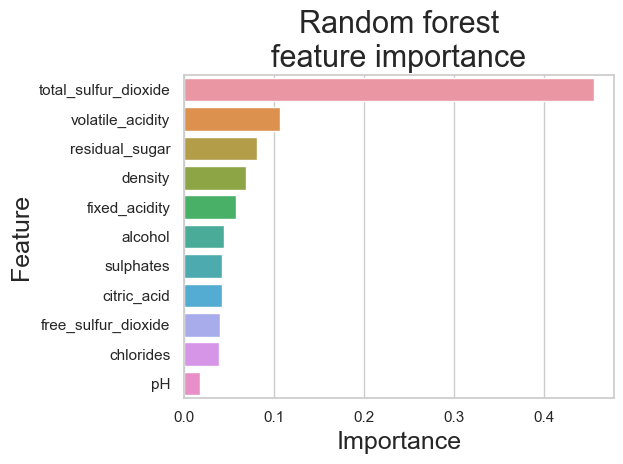

In [83]:
# Calculate feature importance in random forest
importances = regr.feature_importances_
labels = df.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns = ["feature","importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False,)

# image formatting
axis_fs = 18 #fontsize
title_fs = 22 #fontsize
sns.set(style="whitegrid")

ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance',fontsize = axis_fs) 
ax.set_ylabel('Feature', fontsize = axis_fs)#ylabel
ax.set_title('Random forest\nfeature importance', fontsize = title_fs)

plt.tight_layout()
plt.savefig("feature_importance.png",dpi=120) 
plt.show()
plt.close()

Build KNN classification model

In [91]:
# import KNeighbors ClaSSifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

In [92]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=3)

In [93]:
# fit the model to the training set
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# Model Evaluation 

In [98]:
#determine predicted y values 
y_pred = knn.predict(x_test)



In [97]:
# knn model score 
knn.score(x_test, y_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6625

In [99]:
#classification report 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       154
           1       0.68      0.66      0.67       166

    accuracy                           0.66       320
   macro avg       0.66      0.66      0.66       320
weighted avg       0.66      0.66      0.66       320



In [112]:
#confusion matrix 
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
print (cf_matrix)

[[103  51]
 [ 57 109]]


<Axes: >

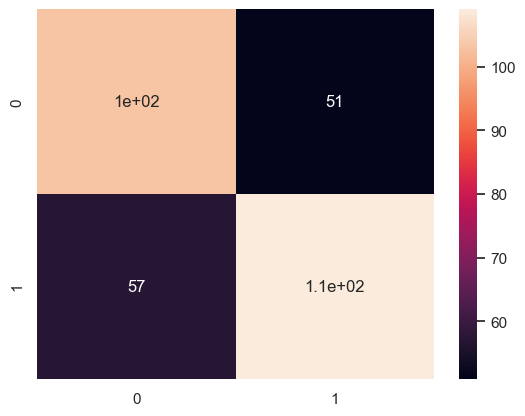

In [113]:
import seaborn as sns

sns.heatmap(cf_matrix, annot=True)

<Axes: >

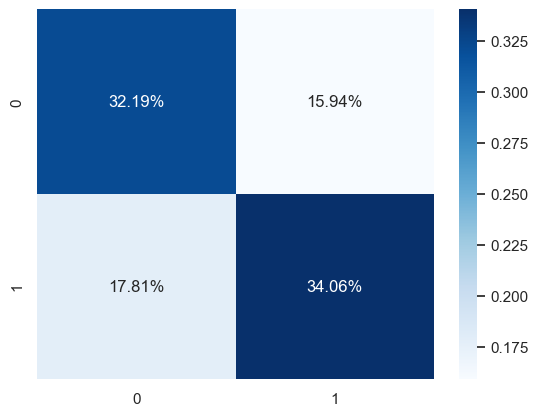

In [115]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# Hyperparameter tuning for random forest regressor

In [129]:
#define knn parameters and args
knn_params = {"n_neighbors": np.arange(2, 50),
             "weights": ["uniform", "distance"],
             "leaf_size": [25, 30, 25]}

knn_cv_model = GridSearchCV(knn, knn_params, cv = 10)
knn_cv_model.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'leaf_size': [25, 30, 25],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['uniform', 'distance']})

In [130]:
# get best parameters for KNN 
print("Best score for train set: " + str(knn_cv_model.best_score_))

print("____________________________________________")

print("best K value: " + str(knn_cv_model.best_params_["n_neighbors"]),
     "\nbest weights: " + knn_cv_model.best_params_["weights"],
     "\nbest leaf size: " + str(knn_cv_model.best_params_["leaf_size"]))

Best score for train set: 0.7483021653543307
____________________________________________
best K value: 21 
best weights: distance 
best leaf size: 25


In [131]:
knn_model = KNeighborsClassifier(n_neighbors = knn_cv_model.best_params_["n_neighbors"],
                                leaf_size = knn_cv_model.best_params_["leaf_size"],
                                weights = knn_cv_model.best_params_["weights"])

knn_model.fit(x_train, y_train)

KNeighborsClassifier(leaf_size=25, n_neighbors=21, weights='distance')

Evaluate hypertuned knn model

In [132]:
#model accuracy score 
y_pred = knn_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.759375

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       154
           1       0.77      0.76      0.77       166

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



In [134]:
cf_matrix = confusion_matrix(y_test, y_pred)
print (cf_matrix)

[[117  37]
 [ 40 126]]


<Axes: >

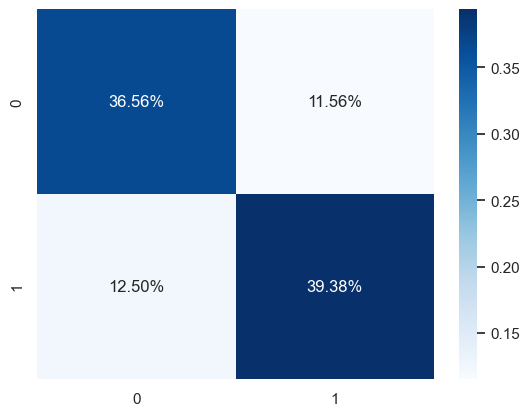

In [135]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')